Modules found on network:
S5-3 | S-0038
S5-3 | S-0009
S5-3 | S-0033
S5-3 | S-0036
S5-3 | S-0025
S5-3 | S-0016
Teach-In Started...
Recording...
Recording done.
Recorded 930 samples.


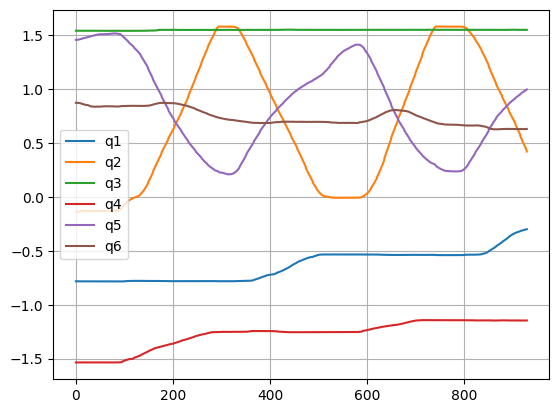

Replay Started...
Finished Replay.
Program Finished.


In [1]:
import hebi
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt

# Initialize HEBI Lookup
lookup = hebi.Lookup()
sleep(2)  # Allow time to discover modules

print('Modules found on network:')
for entry in lookup.entrylist:
    print(f'{entry.family} | {entry.name}')

group = lookup.get_group_from_names(['S5-3'], ['S-0033', 'S-0009', 'S-0025', 'S-0036', 'S-0038', 'S-0016'])
if group is None:
    raise RuntimeError("Group could not be found!")


# Command settings
group_command = hebi.GroupCommand(group.size)
group_feedback = hebi.GroupFeedback(group.size)

# Define parameters
frequency = 100  # Hz
recording_time = 10  # seconds
time_step = 1 / frequency  # time step based on frequency

# Preallocate Q for position data
Q = np.zeros((int(recording_time * frequency), group.size))
row = 0

# Record trajectory
print('Teach-In Started...')
print('Recording...')
start_time = time()
while (time() - start_time) < recording_time:
    # Get feedback
    group.get_next_feedback(reuse_fbk=group_feedback)
    Q[row, :] = group_feedback.position
    row += 1
    
    # Send zero effort command
    group_command.effort = np.zeros(group.size)
    group.send_command(group_command)
    
    # Sleep for the rest of the time step
    sleep(time_step)

print('Recording done.')
print(f'Recorded {row} samples.')

# Trim Q to remove unused rows
Q = Q[:row, :]

# Plot the trajectory
plt.plot(Q)
plt.legend([f'q{i+1}' for i in range(group.size)])
plt.grid(True)
plt.show()

# Pause before playback
sleep(5)
print('Replay Started...')

# Replay recorded trajectory in reverse
for i in range(row-1, -1, -1):
    group_command.position = Q[i, :]
    group.send_command(group_command)
    sleep(time_step)

print('Finished Replay.')

# Reset and finalize
print('Program Finished.')


In [6]:
print(Q.shape)

(930, 6)


In [7]:
# Example joint angle data (replace with real data if available)

def hebi_transformed_matrix(link_length, theta):
    return np.array([[0, -np.cos(theta), np.sin(theta), link_length * np.sin(theta)],
                     [1, 0, 0, 0],
                     [0, np.sin(theta), np.cos(theta), link_length * np.cos(theta)],
                     [0, 0, 0, 1]])


In [10]:
import numpy as np
import pandas as pd

# Length of each link
link_length = 7.0

# Lists to store the origin positions and axis direction vectors for each link
positions = []  # Origin position of each link
x_axes = []     # x-axis direction vector of each link
y_axes = []     # y-axis direction vector of each link
z_axes = []     # z-axis direction vector of each link

# Calculations for each frame in Q
for frame in Q:
    # Joint angles for each link
    theta1, theta2, theta3, theta4, theta5, theta6 = frame
    
    # Transformation matrix for each link
    T12 = hebi_transformed_matrix(link_length, theta1)
    T23 = hebi_transformed_matrix(link_length, theta2)
    T34 = hebi_transformed_matrix(link_length, theta3)
    T45 = hebi_transformed_matrix(link_length, theta4)
    T56 = hebi_transformed_matrix(link_length, theta5)
    T6e = hebi_transformed_matrix(link_length, theta6)
    
    # Calculating positions and axis directions for each link
    transformations = [T12, T23, T34, T45, T56, T6e]
    T_current = np.eye(4)  # Initial transformation matrix (base coordinate system)

    # Lists to store the origin position and axis directions for each link in the current frame
    frame_positions = []
    frame_x_axes = []
    frame_y_axes = []
    frame_z_axes = []

    for T in transformations:
        T_current = T_current @ T  # Update the current transformation matrix

        # Get origin position
        origin = T_current[:3, 3]  # Current origin coordinates
        frame_positions.append(origin)

        # Get each axis direction vector
        x_axis = T_current[:3, 0]  # x-axis direction vector
        y_axis = T_current[:3, 1]  # y-axis direction vector
        z_axis = T_current[:3, 2]  # z-axis direction vector
        frame_x_axes.append(x_axis)
        frame_y_axes.append(y_axis)
        frame_z_axes.append(z_axis)

    # Add data for the current frame
    positions.append(frame_positions)
    x_axes.append(frame_x_axes)
    y_axes.append(frame_y_axes)
    z_axes.append(frame_z_axes)

# Convert results to arrays for easier handling
positions = np.array(positions)  # Origin positions for each link
x_axes = np.array(x_axes)        # x-axis direction vector for each link
y_axes = np.array(y_axes)        # y-axis direction vector for each link
z_axes = np.array(z_axes)        # z-axis direction vector for each link

# Create DataFrames to store the data
df_positions = pd.DataFrame({
    f'position_link_{i+1}': list(positions[:, i]) for i in range(positions.shape[1])
})
df_x_axes = pd.DataFrame({
    f'x_axis_link_{i+1}': list(x_axes[:, i]) for i in range(x_axes.shape[1])
})
df_y_axes = pd.DataFrame({
    f'y_axis_link_{i+1}': list(y_axes[:, i]) for i in range(y_axes.shape[1])
})
df_z_axes = pd.DataFrame({
    f'z_axis_link_{i+1}': list(z_axes[:, i]) for i in range(z_axes.shape[1])
})

# Concatenate the DataFrames
df = pd.concat([df_positions, df_x_axes, df_y_axes, df_z_axes], axis=1)

print("DataFrame with positions and axes data:")
print(df)


DataFrame with positions and axes data:
                                    position_link_1  \
0      [-4.9339446577590005, 0.0, 4.96549998632277]   
1     [-4.9349333852099235, 0.0, 4.964517346483999]   
2      [-4.934656407367862, 0.0, 4.964792658432305]   
3      [-4.935603572518756, 0.0, 4.963851062928872]   
4      [-4.936037888698706, 0.0, 4.963419180497534]   
..                                              ...   
925  [-2.0927226645361214, 0.0, 6.6798586698624725]   
926    [-2.088216716629501, 0.0, 6.681268662790706]   
927   [-2.0813048358759123, 0.0, 6.683425033630551]   
928   [-2.0752223636261906, 0.0, 6.685316158679837]   
929   [-2.0636042628094793, 0.0, 6.688911529278478]   

                                       position_link_2  \
0    [-9.821716959548867, -0.9554071586833262, 9.88...   
1    [-9.823646552580769, -0.9558045719949054, 9.88...   
2    [-9.82348637842076, -0.9517699476218635, 9.883...   
3    [-9.825278596721276, -0.9527337855239337, 9.88...   
4    [-9.

In [11]:
df.describe()

position_link_1  \
count                                            930   
unique                                           930   
top     [-4.9339446577590005, 0.0, 4.96549998632277]   
freq                                               1   

                                          position_link_2  \
count                                                 930   
unique                                                930   
top     [-9.821716959548867, -0.9554071586833262, 9.88...   
freq                                                    1   

                                          position_link_3  \
count                                                 930   
unique                                                930   
top     [-14.927761777373874, -0.983292804579204, 5.09...   
freq                                                    1   

                                          position_link_4  \
count                                                 930   
unique                                                930   
top     [-15.78190393742257, 5.945845823192238, 5.6036...   
freq                                                    1   

                                          position_link_5  \
count                                                 930   
unique                                                930   
top     [-20.588842380239573, 5.780492766081566, 10.68...   
freq                                                    1   

                                          position_link_6    x_axis_link_1  \
count                                                 930              930   
unique                                                930              930   
top     [-19.784483147760653, 5.8841662478509535, 17.6...  [0.0, 1.0, 0.0]   
freq                                                    1                1   

                                          x_axis_link_2  \
count                                               930   
unique                                              930   
top     [-0.7093571409032527, 0.0, -0.7048492368227144]   
freq                                                  1   

                                            x_axis_link_3  \
count                                                 930   
unique                                                930   
top     [0.09620257237898577, -0.9906418982838561, -0....   
freq                                                    1   

                                            x_axis_link_4  ...  \
count                                                 930  ...   
unique                                                930  ...   
top     [-0.6772515661183486, -0.13642858860256557, 0....  ...   
freq                                                    1  ...   

                                            y_axis_link_3  \
count                                                 930   
unique                                                930   
top     [-0.6772515661183486, -0.13642858860256557, 0....   
freq                                                    1   

                                            y_axis_link_4  \
count                                                 930   
unique                                                930   
top     [0.7255627887954837, 0.039126338409497224, 0.6...   
freq                                                    1   

                                            y_axis_link_5  \
count                                                 930   
unique                                                930   
top     [-0.04465654492304527, 0.9989550225722588, -0....   
freq                                                    1   

                                            y_axis_link_6  \
count                                                 930   
unique                                                930   
top     [-0.9923718246737304, -0.04323785430097109, 0....   
freq                                          

Box(children=(VBox(children=(FloatSlider(value=0.0, description='param1', max=90.0, min=-90.0), FloatSlider(va…

Button(description='Reset', style=ButtonStyle())

Button(description='Play', style=ButtonStyle())

IntSlider(value=0, description='Frame', max=929, step=5)

Output()

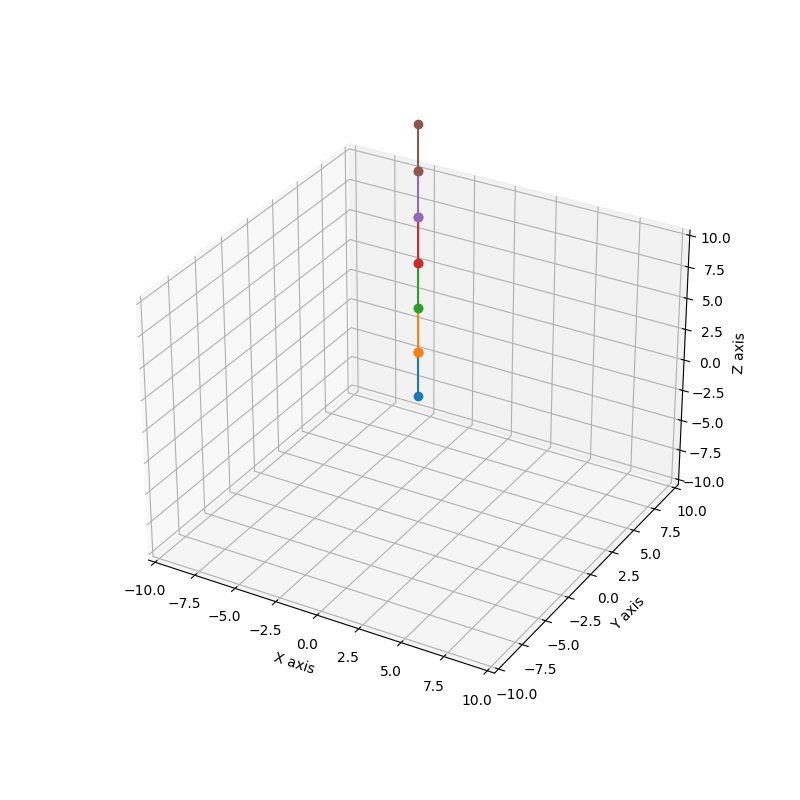

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
from time import sleep
%matplotlib widget

# Example joint angle data (replace with real data if available)

def hebi_transformed_matrix(link_length, theta):
    return np.array([[0, -np.cos(theta), np.sin(theta), link_length * np.sin(theta)],
                     [1, 0, 0, 0],
                     [0, np.sin(theta), np.cos(theta), link_length * np.cos(theta)],
                     [0, 0, 0, 1]])

############# Drawing functions #######################
def init_robot_plot(ax, link_count):
    # Initialize plot lines for each link
    lines = []
    for _ in range(link_count):
        line, = ax.plot([], [], [], "o-", ms=6)  # Create an empty line for each link
        lines.append(line)
    
    # Set plot limits and labels
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-10, 10])
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    
    return lines

def update_robot_plot(lines, points):
    for i, line in enumerate(lines):
        line.set_data([points[i][0, 0], points[i+1][0, 0]], 
                      [points[i][1, 0], points[i+1][1, 0]])
        line.set_3d_properties([points[i][2, 0], points[i+1][2, 0]])

def main(*args, **kwargs):
    params = kwargs
    link_length = 3.5    

    theta_values = [np.deg2rad(params[str(i)]) for i in range(6)]
    matrices = [hebi_transformed_matrix(link_length, theta) for theta in theta_values]

    points = [np.array([[0], [0], [0], [1]])]
    T_current = np.eye(4)

    for T in matrices:
        T_current = T_current @ T
        points.append(T_current @ np.array([[0], [0], [0], [1]]))

    # Update lines without clearing the plot
    update_robot_plot(main.lines, points)
    main.fig.canvas.draw_idle()  # Update canvas more efficiently

def generate_vbox_slider_widget(link_num):
    slider_widgets = []
    for i in range(link_num):
        slider_widgets.append(ipywidgets.FloatSlider(value=0.0, min=-90.0, max=90.0, description=f"param{i+1}", disabled=False))
    return ipywidgets.VBox(slider_widgets)

def update_sliders(frame, sliders):
    # Update each slider with the corresponding value in Q[frame]
    for i, slider in enumerate(sliders.children):
        slider.value = np.rad2deg(Q[frame, i])

def draw_interactive(link_num):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    
    # Initialize robot plot and store lines and fig for updating
    main.lines = init_robot_plot(ax, link_num)
    main.fig = fig

    posture_sliders = generate_vbox_slider_widget(link_num)
    slider_and_text = ipywidgets.Box([posture_sliders])

    reset_button = ipywidgets.Button(description="Reset")
    def reset_values(button):
        for i in range(link_num):
            posture_sliders.children[i].value = 0.0
    reset_button.on_click(reset_values)

    params = {str(i): posture_sliders.children[i] for i in range(link_num)}
    final_widgets = ipywidgets.interactive_output(main, params)

    # Frame control widgets
    play_button = ipywidgets.Button(description="Play")
    frame_slider = ipywidgets.IntSlider(value=0, min=0, max=len(Q)-1, step=5, description="Frame")  # Step size adjusted

    def play_animation(button):
        for frame in range(0, len(Q), 5):  # Skip frames to reduce processing
            update_sliders(frame, posture_sliders)
            frame_slider.value = frame
            sleep(0.05)

    play_button.on_click(play_animation)

    # Update posture sliders when frame slider changes
    def on_frame_slider_change(change):
        update_sliders(change['new'], posture_sliders)
    
    frame_slider.observe(on_frame_slider_change, names="value")

    display(slider_and_text, reset_button, play_button, frame_slider, final_widgets)

draw_interactive(6)


In [12]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# 初期解の設定
initial_theta = np.array(Q)  # Q の各フレームを初期値として設定

# 目標位置と軸方向との差を計算するコスト関数
def cost_function(theta_values):
    total_error = 0
    link_length = 7  # 仮のリンク長さ。実際のリンク長さを使用してください。
    
    # 6つのジョイントの角度を取得
    theta1, theta2, theta3, theta4, theta5, theta6 = theta_values
    transformations = [
        hebi_transformed_matrix(link_length, theta1),
        hebi_transformed_matrix(link_length, theta2),
        hebi_transformed_matrix(link_length, theta3),
        hebi_transformed_matrix(link_length, theta4),
        hebi_transformed_matrix(link_length, theta5),
        hebi_transformed_matrix(link_length, theta6)
    ]
    
    # ベースからリンク末端までの位置と軸方向を計算
    T_current = np.eye(4)
    for i, T in enumerate(transformations):
        T_current = T_current @ T
        origin = T_current[:3, 3]
        x_axis = T_current[:3, 0]
        y_axis = T_current[:3, 1]
        z_axis = T_current[:3, 2]

        # データフレームから目標の位置と軸方向を取得
        target_position = df[f'position_link_{i+1}'].values
        target_x_axis = df[f'x_axis_link_{i+1}'].values
        target_y_axis = df[f'y_axis_link_{i+1}'].values
        target_z_axis = df[f'z_axis_link_{i+1}'].values

        # 位置の誤差と軸方向の誤差を計算
        position_error = np.linalg.norm(origin - target_position)
        x_axis_error = np.linalg.norm(x_axis - target_x_axis)
        y_axis_error = np.linalg.norm(y_axis - target_y_axis)
        z_axis_error = np.linalg.norm(z_axis - target_z_axis)

        # 合計エラーを計算
        total_error += position_error + x_axis_error + y_axis_error + z_axis_error

    return total_error

# 最適化の実行
result = minimize(
    cost_function,
    initial_theta,
    method='BFGS',  # BFGS法を使用。必要に応じて他のメソッドに変更可能。
    options={'disp': True}
)

# 最適化結果の取得
optimized_theta = result.x
print("Optimized Joint Angles (Theta):", optimized_theta)


C:\Users\kenta\AppData\Local\Temp\ipykernel_12028\321542605.py:51: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = minimize(


ValueError: too many values to unpack (expected 6)

In [16]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# 初期解の設定
initial_theta = np.array(Q)  # Q の各フレームを初期値として設定
num_time_steps, num_joints = initial_theta.shape  # タイムステップ数とジョイント数

# 仮のリンク長さ
link_length = 7

# ヘビ変換行列関数（仮の定義）
def hebi_transformed_matrix(link_length, theta):
    # thetaに基づく4x4の変換行列を返す
    T = np.eye(4)
    T[:3, :3] = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    T[:3, 3] = [link_length * np.cos(theta), link_length * np.sin(theta), 0]
    return T

# 目標位置と軸方向との差を計算するコスト関数
def cost_function(theta_values):
    # 1次元配列をタイムステップ × ジョイント数にリシェイプ
    theta_values = theta_values.reshape((num_time_steps, num_joints))  

    total_error = 0
    
    # タイムステップごとに繰り返し計算
    for t in range(num_time_steps):
        theta1, theta2, theta3, theta4, theta5, theta6 = theta_values[t]
        
        # 各リンクの変換行列を計算
        transformations = [
            hebi_transformed_matrix(link_length, theta1),
            hebi_transformed_matrix(link_length, theta2),
            hebi_transformed_matrix(link_length, theta3),
            hebi_transformed_matrix(link_length, theta4),
            hebi_transformed_matrix(link_length, theta5),
            hebi_transformed_matrix(link_length, theta6)
        ]
        
        # ベースからリンク末端までの位置と軸方向を計算
        T_current = np.eye(4)
        for i, T in enumerate(transformations):
            T_current = T_current @ T  # 連続的に変換行列を更新
            origin = T_current[:3, 3]
            x_axis = T_current[:3, 0]
            y_axis = T_current[:3, 1]
            z_axis = T_current[:3, 2]

            # データフレームから目標の位置と軸方向を取得
            target_position = df[f'position_link_{i+1}'].values[t]
            target_x_axis = df[f'x_axis_link_{i+1}'].values[t]
            target_y_axis = df[f'y_axis_link_{i+1}'].values[t]
            target_z_axis = df[f'z_axis_link_{i+1}'].values[t]

            # 位置の誤差と軸方向の誤差を計算
            position_error = np.linalg.norm(origin - target_position)
            x_axis_error = np.linalg.norm(x_axis - target_x_axis)
            y_axis_error = np.linalg.norm(y_axis - target_y_axis)
            z_axis_error = np.linalg.norm(z_axis - target_z_axis)

            # 合計エラーを計算
            total_error += position_error + x_axis_error + y_axis_error + z_axis_error

    return total_error

# コールバック関数
def callback(xk):
    # 中間結果の出力
    current_theta = xk.reshape((num_time_steps, num_joints))
    current_error = cost_function(xk)
    print(f"Current Error: {current_error}")
    print(f"Current Theta: {current_theta}")
# 最適化の実行
result = minimize(
    cost_function,
    initial_theta.flatten(),  # 初期解を1次元にフラット化
    method='BFGS',  # BFGS法を使用。必要に応じて他のメソッドに変更可能。
    options={'disp': True},
    callback = callback
)

# 最適化結果の取得
optimized_theta = result.x.reshape((num_time_steps, num_joints))  # 元の形に戻す
print("Optimized Joint Angles (Theta):", optimized_theta)


KeyboardInterrupt: 

In [18]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# 初期解の設定
initial_theta = np.array(Q)  # Q の各フレームを初期値として設定
num_time_steps, num_joints = initial_theta.shape  # タイムステップ数とジョイント数

# 仮のリンク長さ
link_length = 7

# ヘビ変換行列関数（仮の定義）
def hebi_transformed_matrix(link_length, theta):
    # thetaに基づく4x4の変換行列を返す
    T = np.eye(4)
    T[:3, :3] = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    T[:3, 3] = [link_length * np.cos(theta), link_length * np.sin(theta), 0]
    return T

# 目標位置と軸方向との差を計算するコスト関数
def cost_function(theta_values):
    # 1次元配列をタイムステップ × ジョイント数にリシェイプ
    theta_values = theta_values.reshape((num_time_steps, num_joints))  

    total_error = 0
    
    # タイムステップごとに繰り返し計算
    for t in range(num_time_steps):
        print(t)
        theta1, theta2, theta3, theta4, theta5, theta6 = theta_values[t]
        
        # 各リンクの変換行列を計算
        transformations = [
            hebi_transformed_matrix(link_length, theta1),
            hebi_transformed_matrix(link_length, theta2),
            hebi_transformed_matrix(link_length, theta3),
            hebi_transformed_matrix(link_length, theta4),
            hebi_transformed_matrix(link_length, theta5),
            hebi_transformed_matrix(link_length, theta6)
        ]
        
        # ベースからリンク末端までの位置と軸方向を計算
        T_current = np.eye(4)
        for i, T in enumerate(transformations):
            T_current = T_current @ T  # 連続的に変換行列を更新
            origin = T_current[:3, 3]
            x_axis = T_current[:3, 0]
            y_axis = T_current[:3, 1]
            z_axis = T_current[:3, 2]

            # データフレームから目標の位置と軸方向を取得
            target_position = df[f'position_link_{i+1}'].values[t]
            target_x_axis = df[f'x_axis_link_{i+1}'].values[t]
            target_y_axis = df[f'y_axis_link_{i+1}'].values[t]
            target_z_axis = df[f'z_axis_link_{i+1}'].values[t]

            # 位置の誤差と軸方向の誤差を計算
            position_error = np.linalg.norm(origin - target_position)
            x_axis_error = np.linalg.norm(x_axis - target_x_axis)
            y_axis_error = np.linalg.norm(y_axis - target_y_axis)
            z_axis_error = np.linalg.norm(z_axis - target_z_axis)

            # 合計エラーを計算
            total_error += position_error + x_axis_error + y_axis_error + z_axis_error
            

    return total_error

# コールバック関数
def callback(xk):
    # 中間結果の出力
    current_theta = xk.reshape((num_time_steps, num_joints))
    current_error = cost_function(xk)
    print(f"Current Error: {current_error}")
    print(f"Current Theta: {current_theta}")

# 最適化の実行
result = minimize(
    cost_function,
    initial_theta.flatten(),  # 初期解を1次元にフラット化
    method='BFGS',  # BFGS法を使用。必要に応じて他のメソッドに変更可能。
    options={'disp': True},
    callback=callback  # コールバック関数を設定
)

# 最適化結果の取得
optimized_theta = result.x.reshape((num_time_steps, num_joints))  # 元の形に戻す
print("Optimized Joint Angles (Theta):", optimized_theta)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [19]:
import numpy as np
import sympy as sp

# 変数の定義
theta1, theta2, theta3, theta4, theta5, theta6 = sp.symbols('theta1 theta2 theta3 theta4 theta5 theta6', real=True)
link_length = sp.symbols('link_length', real=True)
vx, vy, vz = sp.symbols('vx vy vz', real=True)

# 変換行列の定義
def hebi_transform(theta):
    return sp.Matrix([
        [0, -sp.cos(theta), sp.sin(theta), link_length * sp.sin(theta)],
        [1, 0, 0, 0],
        [0, sp.sin(theta), sp.cos(theta), link_length * sp.cos(theta)],
        [0, 0, 0, 1]
    ])

# 各リンク間の変換行列
T12 = hebi_transform(theta1)
T23 = hebi_transform(theta2)
T34 = hebi_transform(theta3)
T45 = hebi_transform(theta4)
T56 = hebi_transform(theta5)
T6e = hebi_transform(theta6)

# 全体の変換行列
T02 = T12
T03 = T02 * T23
T04 = T03 * T34
T05 = T04 * T45
T06 = T05 * T56
T0e = T06 * T6e  # 基準座標からエンドエフェクタまでの変換行列

# エンドエフェクタの位置ベクトル
position = T0e[:3, 3]

# ヤコビアン行列の計算
q = [theta1, theta2, theta3, theta4, theta5, theta6]
J = position.jacobian(q)  # ヤコビアン行列

# エンドエフェクタの目標速度ベクトル
velocity_target = sp.Matrix([vx, vy, vz])

# 関節速度の計算（擬似逆行列）
joint_velocity = J.pinv() * velocity_target

# 数値代入と評価
joint_velocity_numeric = joint_velocity.subs({
    theta1: np.deg2rad(30),
    theta2: np.deg2rad(45),
    theta3: np.deg2rad(30),
    theta4: np.deg2rad(60),
    theta5: np.deg2rad(45),
    theta6: np.deg2rad(30),
    link_length: 3.5,
    vx: 0.5,
    vy: 0.5,
    vz: 0.5
})

# 結果を数値に変換して表示
joint_velocity_numeric_evaluated = np.array(joint_velocity_numeric.evalf(), dtype=np.float64)
print("Joint Velocity:\n", joint_velocity_numeric_evaluated)


KeyboardInterrupt: 

In [20]:
import numpy as np
import sympy as sp
import time

# 計測スタート
start_time = time.time()

# 変数の定義
theta1, theta2, theta3, theta4, theta5, theta6 = sp.symbols('theta1 theta2 theta3 theta4 theta5 theta6', real=True)
link_length = sp.symbols('link_length', real=True)
vx, vy, vz = sp.symbols('vx vy vz', real=True)
print("Step 1 - Define Symbols:", time.time() - start_time, "seconds")

# 変換行列の定義
def hebi_transform(theta):
    return sp.Matrix([
        [0, -sp.cos(theta), sp.sin(theta), link_length * sp.sin(theta)],
        [1, 0, 0, 0],
        [0, sp.sin(theta), sp.cos(theta), link_length * sp.cos(theta)],
        [0, 0, 0, 1]
    ])

# 各リンク間の変換行列
T12 = hebi_transform(theta1)
T23 = hebi_transform(theta2)
T34 = hebi_transform(theta3)
T45 = hebi_transform(theta4)
T56 = hebi_transform(theta5)
T6e = hebi_transform(theta6)
print("Step 2 - Compute Transformation Matrices:", time.time() - start_time, "seconds")

# 全体の変換行列
T02 = T12
T03 = T02 * T23
T04 = T03 * T34
T05 = T04 * T45
T06 = T05 * T56
T0e = T06 * T6e  # 基準座標からエンドエフェクタまでの変換行列
print("Step 3 - Compute Total Transformation Matrix:", time.time() - start_time, "seconds")

# エンドエフェクタの位置ベクトル
position = T0e[:3, 3]
print("Step 4 - Extract End-Effector Position:", time.time() - start_time, "seconds")

# ヤコビアン行列の計算
q = [theta1, theta2, theta3, theta4, theta5, theta6]
J = position.jacobian(q)  # ヤコビアン行列
print("Step 5 - Compute Jacobian Matrix:", time.time() - start_time, "seconds")

# エンドエフェクタの目標速度ベクトル
velocity_target = sp.Matrix([vx, vy, vz])

# 関節速度の計算（擬似逆行列）
joint_velocity = J.pinv() * velocity_target
print("Step 6 - Compute Joint Velocity with Pseudo-Inverse:", time.time() - start_time, "seconds")

# 数値代入と評価
joint_velocity_numeric = joint_velocity.subs({
    theta1: np.deg2rad(30),
    theta2: np.deg2rad(45),
    theta3: np.deg2rad(30),
    theta4: np.deg2rad(60),
    theta5: np.deg2rad(45),
    theta6: np.deg2rad(30),
    link_length: 3.5,
    vx: 0.5,
    vy: 0.5,
    vz: 0.5
})
print("Step 7 - Substitute Numeric Values:", time.time() - start_time, "seconds")

# 結果を数値に変換して表示
joint_velocity_numeric_evaluated = np.array(joint_velocity_numeric.evalf(), dtype=np.float64)
print("Step 8 - Evaluate Numeric Result:", time.time() - start_time, "seconds")

# 最終結果の表示
print("Joint Velocity:\n", joint_velocity_numeric_evaluated)
print("Total Time Elapsed:", time.time() - start_time, "seconds")


Step 1 - Define Symbols: 0.0 seconds
Step 2 - Compute Transformation Matrices: 0.004515886306762695 seconds
Step 3 - Compute Total Transformation Matrix: 0.06537961959838867 seconds
Step 4 - Extract End-Effector Position: 0.06537961959838867 seconds
Step 5 - Compute Jacobian Matrix: 0.08429193496704102 seconds


KeyboardInterrupt: 

In [21]:
import numpy as np
import sympy as sp
import time
from scipy.linalg import pinv

# 計測スタート
start_time = time.time()

# 変数の定義
theta1, theta2, theta3, theta4, theta5, theta6 = sp.symbols('theta1 theta2 theta3 theta4 theta5 theta6', real=True)
link_length = sp.symbols('link_length', real=True)
vx, vy, vz = sp.symbols('vx vy vz', real=True)
print("Step 1 - Define Symbols:", time.time() - start_time, "seconds")

# 変換行列の定義
def hebi_transform(theta):
    return sp.Matrix([
        [0, -sp.cos(theta), sp.sin(theta), link_length * sp.sin(theta)],
        [1, 0, 0, 0],
        [0, sp.sin(theta), sp.cos(theta), link_length * sp.cos(theta)],
        [0, 0, 0, 1]
    ])

# 各リンク間の変換行列
T12 = hebi_transform(theta1)
T23 = hebi_transform(theta2)
T34 = hebi_transform(theta3)
T45 = hebi_transform(theta4)
T56 = hebi_transform(theta5)
T6e = hebi_transform(theta6)
print("Step 2 - Compute Transformation Matrices:", time.time() - start_time, "seconds")

# 全体の変換行列
T02 = T12
T03 = T02 * T23
T04 = T03 * T34
T05 = T04 * T45
T06 = T05 * T56
T0e = T06 * T6e  # 基準座標からエンドエフェクタまでの変換行列
print("Step 3 - Compute Total Transformation Matrix:", time.time() - start_time, "seconds")

# エンドエフェクタの位置ベクトル
position = T0e[:3, 3]
print("Step 4 - Extract End-Effector Position:", time.time() - start_time, "seconds")

# ヤコビアン行列の計算
q = [theta1, theta2, theta3, theta4, theta5, theta6]
J = position.jacobian(q)  # ヤコビアン行列
print("Step 5 - Compute Jacobian Matrix:", time.time() - start_time, "seconds")

# lambdifyを使用して数値的に扱えるヤコビアン関数を作成
J_func = sp.lambdify((theta1, theta2, theta3, theta4, theta5, theta6, link_length), J, modules='numpy')

# 数値代入用のパラメータ
params = (np.deg2rad(30), np.deg2rad(45), np.deg2rad(30), np.deg2rad(60), np.deg2rad(45), np.deg2rad(30), 3.5)
J_numeric = np.array(J_func(*params), dtype=np.float64)
print("Step 6 - Compute Numeric Jacobian Matrix:", time.time() - start_time, "seconds")

# エンドエフェクタの目標速度ベクトル
velocity_target = np.array([0.5, 0.5, 0.5])

# 数値的に擬似逆行列を計算
joint_velocity_numeric = pinv(J_numeric).dot(velocity_target)
print("Step 7 - Compute Joint Velocity with Numeric Pseudo-Inverse:", time.time() - start_time, "seconds")

# 最終結果の表示
print("Joint Velocity:\n", joint_velocity_numeric)
print("Total Time Elapsed:", time.time() - start_time, "seconds")


Step 1 - Define Symbols: 0.0 seconds
Step 2 - Compute Transformation Matrices: 0.0039215087890625 seconds
Step 3 - Compute Total Transformation Matrix: 0.053354501724243164 seconds
Step 4 - Extract End-Effector Position: 0.053354501724243164 seconds
Step 5 - Compute Jacobian Matrix: 0.0729062557220459 seconds
Step 6 - Compute Numeric Jacobian Matrix: 0.22751092910766602 seconds
Step 7 - Compute Joint Velocity with Numeric Pseudo-Inverse: 0.23631024360656738 seconds
Joint Velocity:
 [ 0.05886055 -0.0533803  -0.05213637 -0.22053316 -0.14185136 -0.01526246]
Total Time Elapsed: 0.23631024360656738 seconds
